# Determine redshift using machine learning

First, what is redshift and why is it important? Redshift is the equivalent to the distance of stellar objects from us. It is measured using spectroscopy and measuring the redshift (shift of the spectra to the red side of the wavelength). This is important because it allow us to calculate the actual magnitudes of the stellar objects and we can do a lot of fun science with it. Spectra data is not up to par with  the vast optical data available so it is important to have good redshifts from photometry.

The data was obtained using the skyserver from the Sloan Digital Sky Survey (SDSS) using the SQL query. In the SQL query, I specified for no missing values of the redshift or the five bands (u,g,r,i,z). Also the dered values were obtained to account for galactic extinction.

In [1]:
import os
import numpy as np
import pandas as pd
from pandas.plotting import table
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
sns.set()
%matplotlib inline

## Loading data and some EDA

In [2]:
filepath= "/home/veroastro/Documents/spectraTypes/data/"
star = pd.read_csv(filepath+"STAR2_Skyserver_SQL2_12_2022 5_02_48 PM.csv")
QSO = pd.read_csv(filepath+"QSO2Skyserver_SQL2_12_2022 5_03_49 PM.csv")
galaxy = pd.read_csv(filepath+"GALAXY2Skyserver_SQL2_12_2022 5_03_24 PM.csv")

In [3]:
#Create the data frame from the three sets of data
data = pd.concat([star, QSO, galaxy])
#Scramble the data set so that it is not ordered by spectral class (QSO, galaxy or star) 
data = data.sample(frac=1)

data.head()

,#objID,type,dered_u,err_u,dered_g,err_g,dered_r,err_r,dered_i,err_i,dered_z,err_z,specObjID,z,zErr,photoZ,photoErr,zWarning,class,subClass
308,1237648721214767180,3,17.85225,0.011667,16.61216,0.003858,16.18669,0.003685,16.04857,0.003899,15.95690,0.007114,535980346404005888,0.000467,0.000009,0.021198,0.008673,0,STAR,F9
2207,1237651539243696318,3,19.19225,0.028626,18.72476,0.009064,18.20569,0.008330,17.84718,0.008372,17.65723,0.023914,549589544865916928,0.240848,0.000037,0.219226,0.038736,0,QSO,STARBURST BROADLINE
3745,1237657118413357275,3,19.06015,0.030120,18.82117,0.010089,18.30181,0.009393,17.90892,0.009185,17.77618,0.027341,935677836654569472,0.213827,0.000043,0.192504,0.030945,0,QSO,BROADLINE
2784,1237655128772051260,3,18.98371,0.199972,18.08911,0.055290,22.18698,4.085207,20.25719,0.836385,25.28771,2.130757,1097908305394690048,-0.000019,0.000010,-9999.000000,-9999.000000,0,STAR,F5
162,1237650372099440756,3,19.04045,0.024875,17.40755,0.004680,16.72727,0.004058,16.48128,0.004400,16.37112,0.009477,381772455783458816,-0.000177,0.000008,0.045668,0.027466,0,STAR,K1


In [4]:
print('Mean photoError:', round(np.mean(data['photoErr']>0.0), 3))

Mean photoError: 0.954


In [5]:
data['photoErr'].describe()

count    15000.000000
mean      -461.917666
std       2099.047844
min      -9999.000000
25%          0.014778
50%          0.024138
75%          0.041078
max          0.237493
Name: photoErr, dtype: float64

In [6]:
print('Mean specError:', round(np.mean(data['zErr']), 3))

Mean specError: 0.019


The mean value of the spectroscopic errors is 0.019  while the mean value of the photometric errors is 0.954.

In [7]:
cols= ['zWarning','specObjID','#objID','err_u', 'err_g', 'err_r', 'err_i', 'err_z', 'zErr',]
data_clean = data.drop(columns=['zWarning','specObjID','#objID','err_u', 'err_g', 'err_r', 'err_i', 'err_z', 'zErr', 'class', 'subClass', 'photoZ','photoErr','type'])
data_clean.head()

,dered_u,dered_g,dered_r,dered_i,dered_z,z
308,17.85225,16.61216,16.18669,16.04857,15.95690,0.000467
2207,19.19225,18.72476,18.20569,17.84718,17.65723,0.240848
3745,19.06015,18.82117,18.30181,17.90892,17.77618,0.213827
2784,18.98371,18.08911,22.18698,20.25719,25.28771,-0.000019
162,19.04045,17.40755,16.72727,16.48128,16.37112,-0.000177


In [8]:
data_clean.describe()

,dered_u,dered_g,dered_r,dered_i,dered_z,z
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,19.869886,18.452114,17.631055,17.163975,16.934978,0.142970
std,1.702831,1.544044,1.469840,1.371121,1.453392,0.267116
min,11.101360,12.074510,10.785910,10.756660,9.813457,-0.004329
25%,18.870685,17.598865,16.818828,16.356315,16.086430,0.000060
50%,19.614630,18.316495,17.479280,17.038925,16.791815,0.093467
75%,20.553992,19.144298,18.450765,18.022543,17.732482,0.201547
max,29.762490,29.461400,28.317300,28.234270,28.220950,6.827977


In [9]:
def hist_plots( data: pd.DataFrame,
               rows: int,
              cols: int,
              figsize: tuple):
    fig, axes = plt.subplots(rows,cols, figsize=figsize)
    for i, ax in enumerate(axes.flatten()):
        if i < len(data.columns):
            data[sorted(data.columns)[i]].plot.hist(bins=30, ax=ax)
            ax.set_title(f'{sorted(data.columns)[i]} distribution', fontsize=10)
            ax.tick_params(axis='x', labelsize=10)
            ax.tick_params(axis='y', labelsize=10)
            ax.get_yaxis().get_label().set_visible(False)
        else:
            fig.delaxes(ax=ax)
    fig.tight_layout()

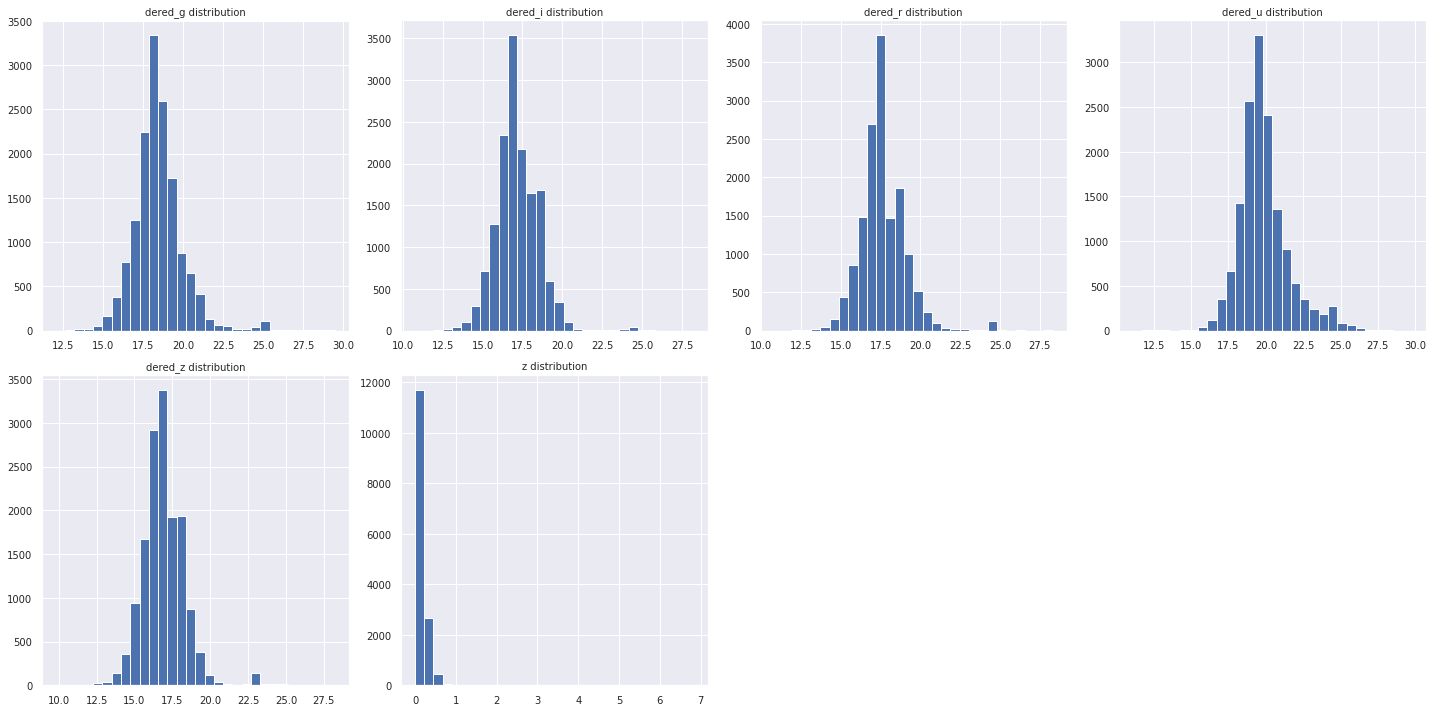

In [10]:
hist_plots(data=data_clean,
          rows=2,
          cols=4,
          figsize=(20,10))
#plt.savefig(filepath+'images/zhistplot.png')

The magnitudes of the bands are in the interquartile ranges (25-75%) between 16-18. The fainter (higher value) sources are mostly outliers of the destributions. Since the distributions are fairly bright, I decided to keep them.

In [11]:
cols= data_clean.columns[:-1]
X = data_clean[cols]
y = data_clean['z']


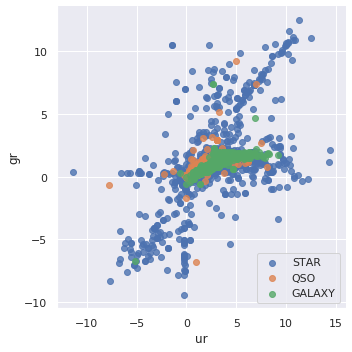

In [12]:
data['ur'] =  data['dered_u'] - data['dered_r']
data['gr'] =  data['dered_g'] - data['dered_r']
# Use the 'hue' argument to provide a factor variable
sns.lmplot( x="ur", y="gr", data=data, fit_reg=False, hue='class', legend=False)
 
# Move the legend to an empty part of the plot
plt.legend(loc='lower right')

plt.show()

As seen by the graph above, colours (the difference in magnitude between 2 bands) gives no extra information.

## Training models

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, random_state=42)

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

LR = LinearRegression()

# Storage for error values
error_df = list()


LR = LR.fit(X_train, y_train)
y_train_pred = LR.predict(X_train)
y_test_pred = LR.predict(X_test)

error_df.append(pd.Series({'train': mean_squared_error(y_train, y_train_pred),
                           'test' : mean_squared_error(y_test,  y_test_pred)}))


In [15]:
error_df

[train    0.063600
 test     0.061024
 dtype: float64]

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
RF = RandomForestRegressor(random_state = 42)
param_grid = {  'bootstrap': [True],
                'max_features': ['log2'], 
                'n_estimators': range(1,400, 40)}

rf= GridSearchCV(RF,
                  param_grid=param_grid)

# Train the model on training data
rf.fit(X_train, y_train);
predictions = rf.predict(X_test)


In [17]:
rf.best_params_ ,rf.best_score_

({'bootstrap': True, 'max_features': 'log2', 'n_estimators': 281},
 0.28150518953963327)

'bootstrap': True, 'max_features': 'log2', 'n_estimators': 121 best parameters of the random forest regressor. 

In [18]:
# Print out the mean square error
print('Mean Square Error RF:', round(mean_squared_error(y_test, predictions), 3))

Mean Square Error RF: 0.053


In [19]:
photozErr= data.loc[(data['photoZ'] >= 0.0)]['photoZ']
sZ= data.loc[(data['photoZ'] >= 0.0)]['z']
print(photozErr.shape)
print('Mean Square Error SDSS:', round(mean_squared_error(sZ,photozErr), 3))

(14307,)
Mean Square Error SDSS: 0.068


The test error of the linear regression model is (mse) 0.0611 while we get an mse of 0.053 with randome forest classifier. To compare errors the mse from the difference between photometric redshift and spectroscopic redshift is 0.068. Here there are values of photoz of -999.0. This are the same as missing values so They are taken out of the calculation of mae.

## Adding spectral types

This is to check if it would reduce the error on the ml determined redshifts.

In [20]:
def type_to_value(n):
    if n == 'STAR':
        return 1
    elif n == 'QSO':
        return 2
    elif n == 'GALAXY':
        return 3
    

data['nClass'] = [type_to_value(n) for n in data['class']]

In [21]:
print(X.head())
X['class'] = data['nClass']

       dered_u   dered_g   dered_r   dered_i   dered_z
308   17.85225  16.61216  16.18669  16.04857  15.95690
2207  19.19225  18.72476  18.20569  17.84718  17.65723
3745  19.06015  18.82117  18.30181  17.90892  17.77618
2784  18.98371  18.08911  22.18698  20.25719  25.28771
162   19.04045  17.40755  16.72727  16.48128  16.37112


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, random_state=42)

In [23]:
rf.fit(X_train, y_train);
predictions_class = rf.predict(X_test)

In [24]:
errors_class = abs(predictions_class - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error RF with class:', round(np.mean(errors_class), 3))

Mean Absolute Error RF with class: 0.034


## Calculating class

Errors were reduced with the spectra types. Now we check if ml determined classes can serve too.

In [25]:
cols =  X.columns[:-1]
new_X = X[cols]
new_y = X['class']
print(new_X.shape, new_y.shape, X.shape)

(15000, 5) (15000,) (15000, 6)


In [26]:
from sklearn.model_selection import StratifiedShuffleSplit

strat_shuf_split = StratifiedShuffleSplit(n_splits=3, 
                                          test_size=0.3, 
                                          random_state=42)

train_idx, test_idx = next(strat_shuf_split.split(new_X,new_y))


X_train_cl = new_X.iloc[train_idx]
y_train_cl = new_y.iloc[train_idx]
X_test_cl  = new_X.iloc[test_idx]
y_test_cl  = new_y.iloc[test_idx]

In [27]:
from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler() 
X_train_cl= mm.fit_transform(X_train_cl) 
X_test_cl= mm.transform(X_test_cl)

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV



RF = RandomForestClassifier(n_estimators = 341,
                            oob_score=True, 
                            random_state=42, 
                            warm_start=True,
                            n_jobs=-1)


rfc = RF.fit(X_train_cl, y_train_cl)

In [29]:
from sklearn.metrics import classification_report

y_pred_rf = rfc.predict(X_test_cl)
cr = classification_report(y_test_cl, y_pred_rf)
print(cr)

              precision    recall  f1-score   support

           1       0.93      0.90      0.91      1500
           2       0.94      0.90      0.92      1500
           3       0.86      0.93      0.89      1500

    accuracy                           0.91      4500
   macro avg       0.91      0.91      0.91      4500
weighted avg       0.91      0.91      0.91      4500



In [30]:
y_class = rfc.predict(new_X)
y_class.shape

(15000,)

In [31]:
X_class = X.drop(['class'], axis =1)
X_class['nclass'] = y_class
X_class.head()

,dered_u,dered_g,dered_r,dered_i,dered_z,nclass
308,17.85225,16.61216,16.18669,16.04857,15.95690,1
2207,19.19225,18.72476,18.20569,17.84718,17.65723,1
3745,19.06015,18.82117,18.30181,17.90892,17.77618,1
2784,18.98371,18.08911,22.18698,20.25719,25.28771,1
162,19.04045,17.40755,16.72727,16.48128,16.37112,1


In [32]:

X_train_cc = X_class.iloc[train_idx]
y_train_cc = y.iloc[train_idx]
X_test_cc  = X_class.iloc[test_idx]
y_test_cc  = y.iloc[test_idx]

X_train_cc= mm.fit_transform(X_train_cc) 
X_test_cc= mm.transform(X_test_cc)

In [33]:
rf.fit(X_train_cc, y_train_cc);
predictions_c = rf.predict(X_test_cc)



In [34]:
# Print out the mean absolute error (mae)
print('Mean Square Error RF with estimated class:', round(mean_squared_error(y_test, predictions_c), 3))

Mean Square Error RF with estimated class: 0.093


In [35]:
rf.best_params_ ,rf.best_score_

({'bootstrap': True, 'max_features': 'log2', 'n_estimators': 241},
 0.29689011117585357)

## Conclusion

I was able to improve on the accuracy of the SDSS photometric redshift slightly; 0.053 against the 0.068 of the SDSS. Also to note is that the redshift was calculated for all 15000 sources. The SDSS has photometry for 14307 of those 15000.

Using the spectra clasification, the means square error was reduced to 0.034. But using estimated classes yielded an error of 0.093. 

Better estimation of the classes might help reduce the errors on the estimation of redshifts. Also, once since missing from my estimated redshift is an estimation of the errors without the use of the spectral redshift.